## Language Models Lab ##

Through these notebooks, we will explore different important and interesting techniques, approaches, and uses of language models to address mainly Natural Language Processing tasks.

We will explore the following:

- Creating Recurrent Neural Networks (RNN) and Long short-term memory (LSTM) networks
- Word2Vec
    - Continuous Bag-Of-Words (CBOW)
- Using RNNS in practice!
    - Text classification
- Seq2Seq
    - Using Torchtext
    - Machine Translation
- Using Pre-trained models!

### Assignments ###

#### Mandatory: ####

- Compare RNN, LSTM, and GRU with perplexity
    - Implement GRU in this Notebook
- Implement Skip-gram and compare embeddings with CBOW
- Adapt/expand the text classifier example to one of the proposed ones in the notebook
    - Use LSTMs or GRU to compare with the current approach (RNN)
    - Possible tasks
        - Book or character name -> writer
        - Game's titles -> company or genre
        - Any word -> language
        - Whatever you can think it can be classified

- Implement and test Pytorch’s own Transformer models for machine translation
    - Analyze based on the output and measurements.
    - Compare to provided example seq2seq
    
#### Advanced: ####

- Use RNNs, LSTMs, GRUs, or Transformer for text generation
    - Specifically, you should/could generate:
        - Names based on countries
        - Cities based on countries
        - Game ideas based on genres
- Fine-tune any of the hugginface models to any specific task you are interested on such as:
    - Generation of quests
    - Chatbot
    - Recipe generation

-------------
## Basic testing of RNN, LSTM, and GRU ##

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# What will happen here?
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"]),
    ("Everybody does machine learning nowadays".split(), ["NN", "V", "NN", "NN", "ADV", ])
]

#vocabulary
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
print(word_to_ix)

#Possible classes
tag_to_ix = {"DET": 0, "NN": 1, "V": 2, "ADV": 3}  # Assign each tag with a unique index

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8, 'does': 9, 'machine': 10, 'learning': 11, 'nowadays': 12}


In [3]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 12
VOCAB_SIZE = len(word_to_ix)
NUM_CLASSES = len(tag_to_ix)

In [4]:
def train(model, optimizer, criterion, epochs):
    epoch_loss = []
    for epoch in range(epochs):  # again, normally you would NOT do 300 epochs, it is toy data
        final_loss = 0
        for sentence, tags in training_data:
            
            model.zero_grad()

            # get inputs and targets ready for the network!
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)

            # get the tag scores
            tag_scores = model(sentence_in)
            
            loss = criterion(tag_scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            final_loss += loss.item()
        epoch_loss.append(final_loss)
    
    return epoch_loss


In [5]:
def evaluate(model, test_sequence):
    with torch.no_grad():
        inputs = prepare_sequence(training_data[test_sequence][0], word_to_ix)
        tag_scores = model(inputs)
        
        outputs = []
        
        print(tag_to_ix)
        print(training_data[test_sequence][0])
        print(training_data[test_sequence][1])
        
        for tag_score in tag_scores:
            outputs.append(tag_score.topk(1).indices.item())
            
        print(outputs)
        print("--------------")

### Recurrent Neural Networks (RNN) ###

In [6]:
class RNNTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RNNTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The RNN takes word embeddings as inputs, and outputs hidden states and output
        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        
        embeds = self.word_embeddings(sentence)
        rnn_out, _ = self.rnn(embeds.view(len(sentence), 1, -1)) #The module is expecting [sentence_length, batch_size, embedding_dim] [sentence_length, 1, 6]
        
        # in this case, rnn_out.view(len(sentence), -1) is the same as doing what function?
        tag_space = self.hidden2tag(rnn_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [7]:
model = RNNTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
losses = train(model, optimizer, loss_function, 100)
print(losses)

loss = torch.FloatTensor(losses)
perplexity  = torch.exp(loss)
print("Perplexity:", perplexity ,"\n")  

evaluate(model, 0)
evaluate(model, 1)
evaluate(model, 2)


[4.017087936401367, 3.687728762626648, 3.429865837097168, 3.222933292388916, 3.0489230155944824, 2.8919837474823, 2.7402908205986023, 2.586885154247284, 2.4293200373649597, 2.2686046957969666, 2.1077007055282593, 1.950084924697876, 1.7988740801811218, 1.656463086605072, 1.5243872702121735, 1.4032939970493317, 1.2930443584918976, 1.1929331123828888, 1.1019536256790161, 1.0190259218215942, 0.9431486278772354, 0.8734757602214813, 0.8093356043100357, 0.7502153962850571, 0.6957278698682785, 0.6455713957548141, 0.5994946360588074, 0.5572682395577431, 0.5186662003397942, 0.4834563583135605, 0.4513980373740196, 0.42224517464637756, 0.3957502916455269, 0.37167133390903473, 0.34977563470602036, 0.32984543591737747, 0.31167886406183243, 0.2950921393930912, 0.27991941571235657, 0.266011793166399, 0.253236997872591, 0.241477333009243, 0.23062866926193237, 0.22059904783964157, 0.21130693331360817, 0.2026802822947502, 0.19465571269392967, 0.1871761977672577, 0.1801920011639595, 0.17365846782922745, 0

#### Visualise the loss with a plot

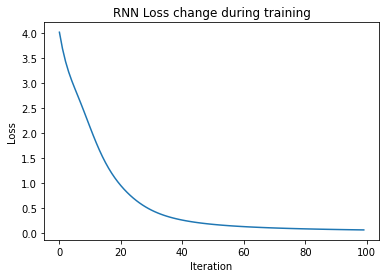

In [8]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('RNN Loss change during training')
plt.show()

### Long Short-Term Memory (LSTM) ###

In [9]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [10]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
losses = train(model, optimizer, loss_function, 100)
print(losses)

loss = torch.FloatTensor(losses)
perplexity  = torch.exp(loss)
print("Perplexity:", perplexity ,"\n") 

evaluate(model, 0)
evaluate(model, 1)
evaluate(model, 2)

[4.103051543235779, 4.021551012992859, 3.9526424407958984, 3.894487738609314, 3.84543514251709, 3.8040281534194946, 3.7690006494522095, 3.7392690181732178, 3.71391499042511, 3.692169666290283, 3.6733914613723755, 3.6570515632629395, 3.6427143812179565, 3.630022883415222, 3.6186846494674683, 3.6084614992141724, 3.5991588830947876, 3.5906171798706055, 3.582706332206726, 3.5753201246261597, 3.5683703422546387, 3.561784863471985, 3.555503010749817, 3.5494751930236816, 3.5436588525772095, 3.5380183458328247, 3.532523512840271, 3.527147889137268, 3.5218684673309326, 3.516666054725647, 3.5115225315093994, 3.5064220428466797, 3.501351237297058, 3.4962962865829468, 3.491245985031128, 3.4861884117126465, 3.4811140298843384, 3.476012945175171, 3.4708757400512695, 3.4656938314437866, 3.4604583978652954, 3.4551610946655273, 3.449794054031372, 3.4443494081497192, 3.4388192892074585, 3.4331958293914795, 3.4274712800979614, 3.4216384887695312, 3.415689468383789, 3.409616708755493, 3.4034124612808228, 

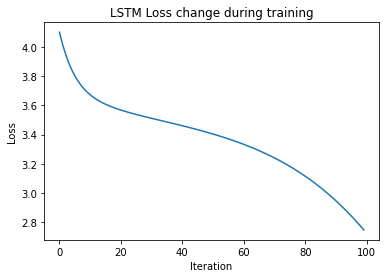

In [11]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('LSTM Loss change during training')
plt.show()

# Lab assignment below
## Replace LSTM and RNN with GRU ##

Implement a network with nn.GRU, and compare with the other networks through loss and perplexity. If wanted, you can extend this toy example with more sentences or vary the task for testing the networks and observing the differences.

In [12]:
class GRUnet(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(GRUnet, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.gru = nn.GRU(embedding_dim, hidden_dim)

        # linear layer maps hidden state space  --> tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        gru_out, _ = self.gru(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(gru_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [13]:
model = GRUnet(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
losses = train(model, optimizer, loss_function, 100)
print("loss", losses, "\n")

loss = torch.FloatTensor(losses)
perplexity  = torch.exp(loss)
print("Perplexity:", perplexity ,"\n")  

evaluate(model, 0)
evaluate(model, 1)
evaluate(model, 2)




loss [4.619685173034668, 4.307417154312134, 4.065161943435669, 3.8773343563079834, 3.7324488162994385, 3.620567560195923, 3.532819628715515, 3.461726427078247, 3.4014667868614197, 3.3478248715400696, 3.2979109287261963, 3.249820053577423, 3.2023309469223022, 3.1546781063079834, 3.106396734714508, 3.0572206377983093, 3.007018506526947, 2.955751061439514, 2.9034414887428284, 2.850155770778656, 2.7959868907928467, 2.7410438656806946, 2.68544340133667, 2.629306375980377, 2.5727538466453552, 2.5159056186676025, 2.4588780999183655, 2.4017857909202576, 2.3447383642196655, 2.2878409028053284, 2.231192708015442, 2.1748847663402557, 2.1189988255500793, 2.0636050701141357, 2.008760154247284, 1.9545093476772308, 1.9008837938308716, 1.8479042053222656, 1.7955822944641113, 1.7439239919185638, 1.6929315328598022, 1.6426074802875519, 1.5929559469223022, 1.5439852178096771, 1.4957094490528107, 1.4481476843357086, 1.401325136423111, 1.3552713096141815, 1.3100193738937378, 1.2656039893627167, 1.222059279

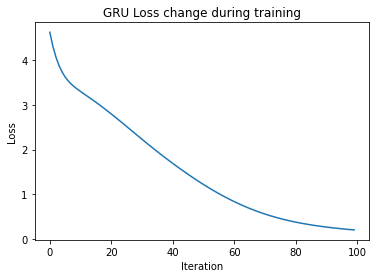

In [14]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('GRU Loss change during training')
plt.show()